# Exercise 2-6
Author: Sebastian Pritz

In [1]:
data_dir = "src/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from pyMLaux import evaluate_regression_result

## Load Data Set

In [3]:
energy_data = pd.read_csv(data_dir+"energydata_complete.csv")
energy_data.drop(['rv1', 'rv2'], axis=1, inplace=True)
energy_data['date'] = pd.to_datetime(energy_data['date'])
energy_data.set_index('date', inplace=True)

In [4]:
energy_data_plus = energy_data.copy()
hour = pd.to_datetime(energy_data_plus.index).hour
doy = pd.to_datetime(energy_data_plus.index).day_of_year
dow = pd.to_datetime(energy_data_plus.index).day_of_week
energy_data_plus = pd.concat([energy_data_plus,
                              pd.DataFrame({'hour': hour, 'day_of_week': dow, 'day_of_year': doy}, index=energy_data_plus.index)],
                             axis=1)
energy_data_plus.tail()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,hour,day_of_week,day_of_year
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,17,4,148
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,17,4,148
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,17,4,148
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,17,4,148
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,18,4,148


In [5]:
y_appl = np.array(energy_data['Appliances'])
y_light = np.array(energy_data['lights'])
X = np.array(energy_data.iloc[:, 2:])

## Appliances

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_appl, test_size=0.3, random_state=4232)

### RBF SVR

In [7]:
pipeline = make_pipeline(StandardScaler(), NuSVR(kernel='rbf', nu=0.2))
parameters = {'nusvr__C': [8, 128, 1024, 1536], 'nusvr__gamma': [0.01, 0.5, 1, 5, 10]}
svmR_models = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring="r2", verbose=3)
svmR_models.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('nusvr', NuSVR(nu=0.2))]),
             n_jobs=-1,
             param_grid={'nusvr__C': [8, 128, 1024, 1536],
                         'nusvr__gamma': [0.01, 0.5, 1, 5, 10]},
             scoring='r2', verbose=3)

In [8]:
svmR_models.best_score_

0.4887020852360953

In [9]:
svmR_models.best_params_

{'nusvr__C': 1024, 'nusvr__gamma': 0.5}

In [10]:
svmR_models.best_estimator_.score(X_test, y_test)

0.5524624292775241

In [11]:
pred = svmR_models.best_estimator_.predict(X_test)

In [12]:
evaluate_regression_result(y_test, pred)

Mean squared error (MSE): 4672.88
Root mean squared error (RMSE): 68.36
Mean absolute error (MAE): 30.61
Coefficient of determination (R2): 0.55
Correlation coefficient (Pearson): 0.75 (p = 0.0)


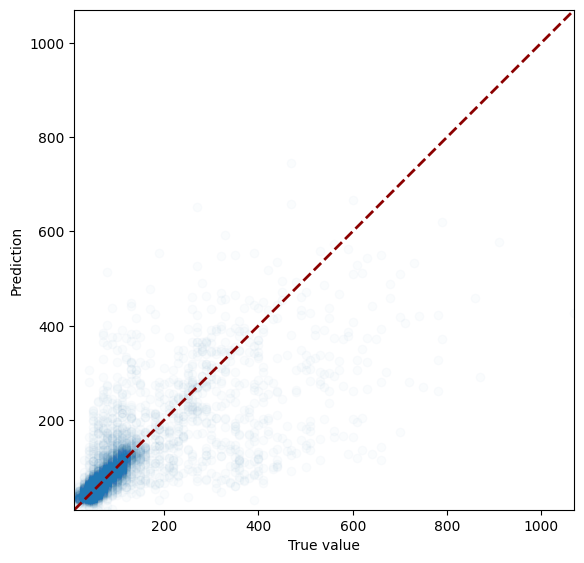

In [13]:
lower, upper = min(y_test), max(y_test)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(y_test, pred, alpha=0.02)
ax.plot((lower, upper), (lower, upper), linewidth=2, linestyle='dashed', color='darkred')
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
ax.set_xlabel('True value')
ax.set_ylabel('Prediction')
plt.show()

### Random Forest

In [14]:
rf_model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
parameters = {'n_estimators': [500, 1000, 1500], 'max_features': [4, 8, 16] , 'max_depth': [None]}
rf_models = GridSearchCV(rf_model, parameters, cv=3, n_jobs=-1, scoring="r2", verbose=3)
rf_models.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_estimators=1000, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': [4, 8, 16],
                         'n_estimators': [500, 1000, 1500]},
             scoring='r2', verbose=3)

In [15]:
rf_models.best_score_

0.5002210875551282

In [16]:
rf_models.best_params_

{'max_depth': None, 'max_features': 4, 'n_estimators': 1500}

In [17]:
rf_models.best_estimator_.score(X_test, y_test)

0.5628046373068837

In [18]:
evaluate_regression_result(y_test, pred)

Mean squared error (MSE): 4672.88
Root mean squared error (RMSE): 68.36
Mean absolute error (MAE): 30.61
Coefficient of determination (R2): 0.55
Correlation coefficient (Pearson): 0.75 (p = 0.0)


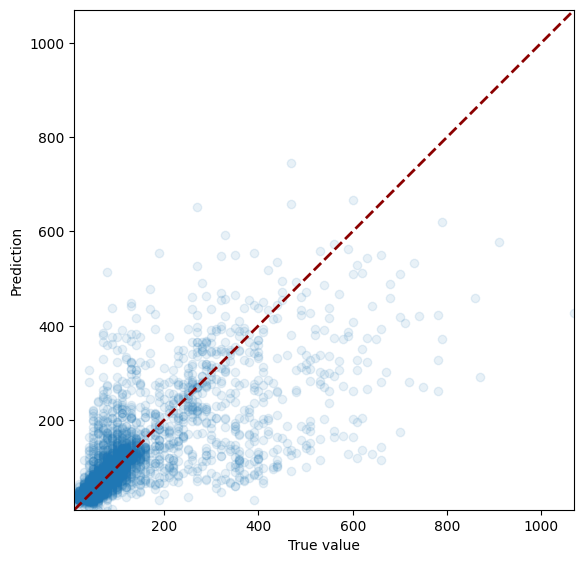

In [19]:
lower, upper = min(y_test), max(y_test)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(y_test, pred, alpha=0.1)
ax.plot((lower, upper), (lower, upper), linewidth=2, linestyle='dashed', color='darkred')
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
ax.set_xlabel('True value')
ax.set_ylabel('Prediction')
plt.show()

## Interpretation

Die Vorhersage stimmt für kleine Werte, aber bei höheren Werten gibt es eine größere Streuung der Ergebnisse, und das ist bei beiden Modellen so. Beim nu-SVR Modell sieht es allerdings aufgrund der Transparenz so aus, als sei es schlechter. Die Ergebnisse für das nu-SVR Modell (Train: 0.48, Test: 0.55) sind nur leicht weniger schlecht, wie jene des Random Forest Modells (Train: 0.5, Test: 0.56). 

## Lights

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y_light, test_size=0.3, random_state=4232)

### RBF SVR

In [21]:
pipeline = make_pipeline(StandardScaler(), NuSVR(kernel='rbf', nu=0.2))
parameters = {'nusvr__C': [8, 128, 1024, 1536], 'nusvr__gamma': [0.01, 0.5, 1, 5, 10]}
svmR_models = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, scoring="r2", verbose=3)
svmR_models.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('nusvr', NuSVR(nu=0.2))]),
             n_jobs=-1,
             param_grid={'nusvr__C': [8, 128, 1024, 1536],
                         'nusvr__gamma': [0.01, 0.5, 1, 5, 10]},
             scoring='r2', verbose=3)

In [22]:
svmR_models.best_score_

0.5839216108895473

In [23]:
svmR_models.best_params_

{'nusvr__C': 128, 'nusvr__gamma': 0.5}

In [34]:
svmR_models.best_estimator_.score(X_test, y_test)

0.644966890923079

In [24]:
pred = svmR_models.best_estimator_.predict(X_test)

In [25]:
evaluate_regression_result(y_test, pred)

Mean squared error (MSE): 22.76
Root mean squared error (RMSE): 4.77
Mean absolute error (MAE): 3.04
Coefficient of determination (R2): 0.64
Correlation coefficient (Pearson): 0.81 (p = 0.0)


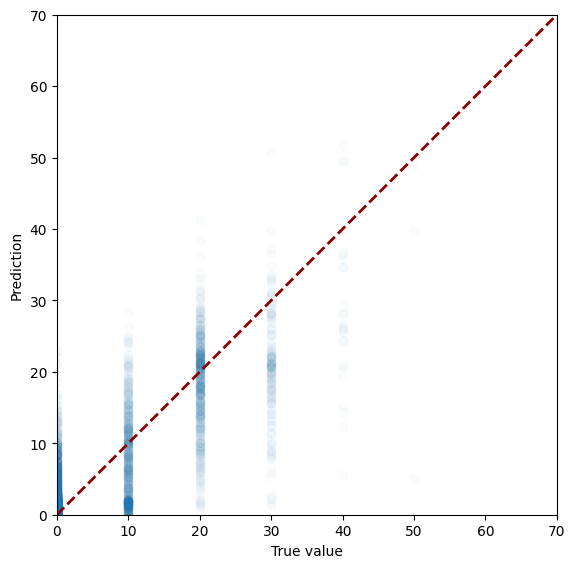

In [26]:
lower, upper = min(y_test), max(y_test)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(y_test, pred, alpha=0.02)
ax.plot((lower, upper), (lower, upper), linewidth=2, linestyle='dashed', color='darkred')
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
ax.set_xlabel('True value')
ax.set_ylabel('Prediction')
plt.show()

### Random Forest

In [27]:
rf_model = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
parameters = {'n_estimators': [500, 1000, 1500], 'max_features': [4, 8, 16] , 'max_depth': [None]}
rf_models = GridSearchCV(rf_model, parameters, cv=3, n_jobs=-1, scoring="r2", verbose=3)
rf_models.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_estimators=1000, n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': [4, 8, 16],
                         'n_estimators': [500, 1000, 1500]},
             scoring='r2', verbose=3)

In [28]:
rf_models.best_score_

0.641156261116889

In [29]:
rf_models.best_params_

{'max_depth': None, 'max_features': 4, 'n_estimators': 1000}

In [30]:
rf_models.best_estimator_.score(X_test, y_test)

0.7012801823456558

In [31]:
evaluate_regression_result(y_test, pred)

Mean squared error (MSE): 22.76
Root mean squared error (RMSE): 4.77
Mean absolute error (MAE): 3.04
Coefficient of determination (R2): 0.64
Correlation coefficient (Pearson): 0.81 (p = 0.0)


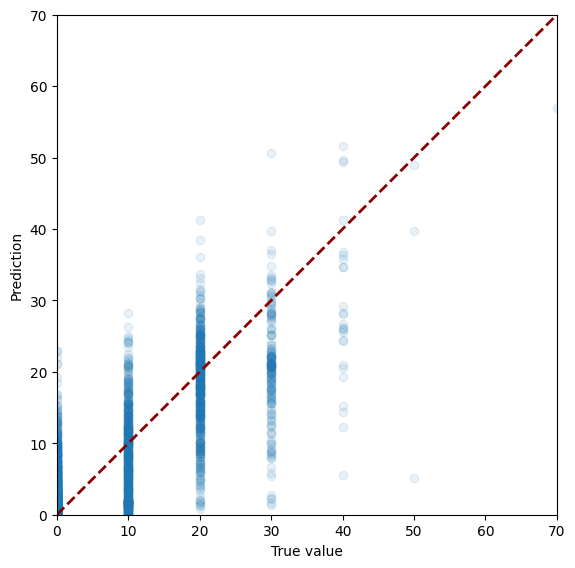

In [33]:
# lower, upper = min(y_test), max(y_test)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.scatter(y_test, pred, alpha=0.1)
ax.plot((lower, upper), (lower, upper), linewidth=2, linestyle='dashed', color='darkred')
ax.set_xlim(lower, upper)
ax.set_ylim(lower, upper)
ax.set_xlabel('True value')
ax.set_ylabel('Prediction')
plt.show()

## Interpretation

Die Ergebnisse für das nu-SVR Modell (Train: 0.58, Test: 0.64) sind wieder schlechter - und nun mit größerem Abstand - wie jene des Random Forest Modells (Train: 0.64, Test: 0.7). Das ist vor allem in den Plots zu sehen, wo die Hotspots (dichtesten Regionen der vertikalen Striche) beim RF Modell näher an der Linie liegen.